In [51]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
import math
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from hyperopt import hp, fmin, tpe, Trials
import shap
from catboost.utils import get_roc_curve
from catboost import Pool
from lightgbm import LGBMRegressor
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt

import wandb
from transformers import AutoModel

In [45]:
wandb.login()

True

In [46]:
 wandb.init(project="ml8")

In [ ]:

model = AutoModel.from_pretrained("jwan2021/autotrain-us-housing-prices-1771761511")

In [2]:
org_data_train = pd.read_csv('autoam-car-price-prediction/train.csv')
org_data_test = pd.read_csv('autoam-car-price-prediction/test.csv')
save_data_train = deepcopy(org_data_train)
save_data_test = deepcopy(org_data_test)

In [3]:
def km_mile_convert(value):
    if 'km' in value:
        return float(value.replace(' km', ''))  # km를 miles로 변환
    elif 'miles' in value:
        return round(float(value.replace(' miles', '')) * 1.60934, 2) # 그대로 반환
    
org_data_train['running'] = org_data_train['running'].apply(km_mile_convert)
org_data_test['running'] = org_data_test['running'].apply(km_mile_convert)



# wheel 데이터는 전부 left여서 컬럼자체를 드랍
org_data_train.drop('wheel', axis=1, inplace=True)

# 상관관계 분석결과 motor_volume은 관계성이 0에 가까우므로 우선 드랍
org_data_train.drop('motor_volume', axis=1, inplace=True)


# test에 적용
org_data_test.drop('wheel', axis=1, inplace=True)
org_data_test.drop('motor_volume', axis=1, inplace=True)


In [4]:
# moter_type 원핫 인코딩, 범주가 5개이며, 데이터가 불균형하여 해당 인코딩 선택
one_hot_motor_type = deepcopy(org_data_train['motor_type'])
one_hot_motor_type = pd.get_dummies(one_hot_motor_type, dtype = int)
org_data_train.drop('motor_type', axis=1, inplace=True)
org_data_train = pd.concat([org_data_train, one_hot_motor_type], axis=1)

# test에 적용
one_hot_motor_type = deepcopy(org_data_test['motor_type'])
one_hot_motor_type = pd.get_dummies(one_hot_motor_type, dtype = int)
org_data_test.drop('motor_type', axis=1, inplace=True)
org_data_test = pd.concat([org_data_test, one_hot_motor_type], axis=1)


# mean 값의 차이가 10%이하인 color 데이터를 other로 변경
low_color = ['red', 'cherry', 'brown', 'pink']

org_data_train['color'] = org_data_train['color'].replace({'red' : 'other', 'cherry' : 'other', 
                                                          'brown' : 'other', 'pink' : 'other'})


# test에도 적용
org_data_test['color'] = org_data_test['color'].replace({'red' : 'other', 'cherry' : 'other', 
                                                          'brown' : 'other', 'pink' : 'other'})


# 전체 원핫 인코딩, 범주가 5개이며, 데이터가 불균형하여 해당 인코딩 선택
one_hot_motor_type = deepcopy(org_data_train[['type', 'model', 'color', 'status']])
one_hot_motor_type = pd.get_dummies(one_hot_motor_type, dtype = int)

one_hot_org_data = deepcopy(org_data_train).drop(['type', 'model', 'color', 'status'], axis=1)
one_hot_org_data = pd.concat([one_hot_org_data, one_hot_motor_type], axis=1)
#org_data_train.drop('motor_type', axis=1, inplace=True)
#org_data_train = pd.concat([org_data_train, one_hot_motor_type], axis=1)

# 전체 원핫 인코딩, 범주가 5개이며, 데이터가 불균형하여 해당 인코딩 선택
one_hot_motor_type = deepcopy(org_data_test[['type', 'model', 'color', 'status']])
one_hot_motor_type = pd.get_dummies(one_hot_motor_type, dtype = int)

one_hot_test_data = deepcopy(org_data_test).drop(['type', 'model', 'color', 'status'], axis=1)
one_hot_test_data = pd.concat([one_hot_test_data, one_hot_motor_type], axis=1)
#org_data_train.drop('motor_type', axis=1, inplace=True)
#org_data_train = pd.concat([org_data_train, one_hot_motor_type], axis=1)


#test하고 train셋에서 motor type확인해보면 test에서 diesel과 hybrid가 없음, 컬럼제거함
one_hot_org_data = one_hot_org_data.drop(columns=['diesel', 'hybrid'])
del_000_list = one_hot_org_data[(one_hot_org_data['gas'] == 0) & (one_hot_org_data['petrol'] == 0) & (one_hot_org_data['petrol and gas'] == 0)].index
one_hot_org_data = one_hot_org_data.drop(del_000_list)

In [26]:
one_hot_org_data = one_hot_org_data.drop_duplicates()
one_hot_org_data = one_hot_org_data.reset_index(drop=True)

In [28]:
one_hot_org_data = one_hot_org_data[['year', 'running', 'price', 'gas', 'petrol', 'petrol and gas',
       'type_Coupe', 'type_Universal', 'type_hatchback',
       'type_minivan / minibus', 'type_pickup', 'type_sedan', 'type_suv',
       'model_hyundai', 'model_kia', 'model_mercedes-benz', 'model_nissan',
       'model_toyota', 'color_beige', 'color_black',
       'color_blue', 'color_clove', 'color_gray', 'color_green',
       'color_orange', 'color_other', 'color_silver', 'color_skyblue',
       'color_white', 'status_crashed', 'status_excellent',
       'status_good', 'status_new', 'status_normal']]

In [29]:
print(one_hot_test_data.columns)
print(one_hot_org_data.columns)
print(one_hot_org_data.info())
print(one_hot_test_data.info())

Index(['Id', 'year', 'running', 'gas', 'petrol', 'petrol and gas',
       'type_Coupe', 'type_Universal', 'type_hatchback', 'type_sedan',
       'type_suv', 'model_hyundai', 'model_kia', 'model_mercedes-benz',
       'model_nissan', 'model_toyota', 'color_beige', 'color_black',
       'color_blue', 'color_clove', 'color_gray', 'color_green',
       'color_orange', 'color_other', 'color_silver', 'color_skyblue',
       'color_white', 'status_crashed', 'status_excellent', 'status_good',
       'status_new', 'status_normal'],
      dtype='object')
Index(['year', 'running', 'price', 'gas', 'petrol', 'petrol and gas',
       'type_Coupe', 'type_Universal', 'type_hatchback',
       'type_minivan / minibus', 'type_pickup', 'type_sedan', 'type_suv',
       'model_hyundai', 'model_kia', 'model_mercedes-benz', 'model_nissan',
       'model_toyota', 'color_beige', 'color_black', 'color_blue',
       'color_clove', 'color_gray', 'color_green', 'color_orange',
       'color_other', 'color_silver', 

Explained Variance Ratio by Each Principal Component:
PC1: 0.3703
PC2: 0.2342
PC3: 0.1586
PC4: 0.1219
PC5: 0.0913
PC6: 0.0098
PC7: 0.0051
PC8: 0.0039
PC9: 0.0026
PC10: 0.0017
PC11: 0.0005

Cumulative Explained Variance Ratio:
PC1: 0.3703
PC2: 0.6045
PC3: 0.7631
PC4: 0.8850
PC5: 0.9763
PC6: 0.9861
PC7: 0.9912
PC8: 0.9952
PC9: 0.9978
PC10: 0.9995
PC11: 1.0000


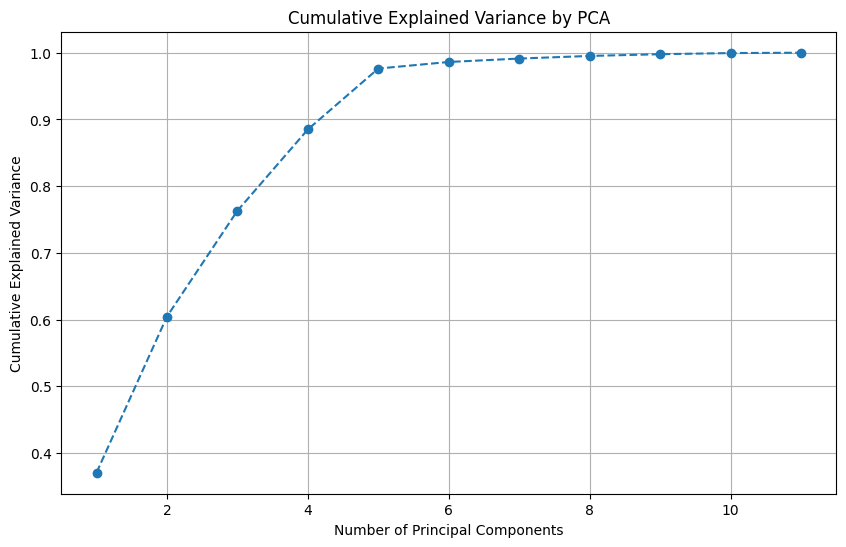

In [30]:
# PCA
c = ['color_beige', 'color_black',
       'color_blue', 'color_clove', 'color_gray', 'color_green',
       'color_orange', 'color_other', 'color_silver', 'color_skyblue',
       'color_white']
pca = PCA(n_components = len(c))  # 모든 주성분을 추출
pca.fit(one_hot_org_data[['color_beige', 'color_black', 'color_blue',
       'color_clove', 'color_gray', 'color_green',
       'color_orange', 'color_other', 'color_silver',
       'color_skyblue', 'color_white']])
explained_variance_ratio = pca.explained_variance_ratio_


# 결과 출력
print("Explained Variance Ratio by Each Principal Component:")
for i, variance in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {variance:.4f}")

# 누적 분산 설명량 계산
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# 누적 분산 설명량 출력
print("\nCumulative Explained Variance Ratio:")
for i, cumulative_variance in enumerate(cumulative_explained_variance):
    print(f"PC{i+1}: {cumulative_variance:.4f}")
    
# 누적 분산 설명량 그래프
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(c) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [31]:
one_hot_org_data[['color_beige', 'color_black', 'color_blue',
       'color_clove', 'color_gray', 'color_green',
       'color_orange', 'color_other', 'color_silver',
       'color_skyblue', 'color_white']]

,color_beige,color_black,color_blue,color_clove,color_gray,color_green,color_orange,color_other,color_silver,color_skyblue,color_white
0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1625,0,0,0,0,0,0,0,0,0,0,1
1626,0,1,0,0,0,0,0,0,0,0,0
1627,0,0,1,0,0,0,0,0,0,0,0
1628,0,1,0,0,0,0,0,0,0,0,0


In [34]:
pca_transformed_train

array([[-0.09658707, -0.17982197, -0.05669221,  0.08189058,  0.06956709],
       [ 0.70888698,  0.2244063 ,  0.03399448, -0.03298598, -0.01896323],
       [-0.12471668, -0.27990732, -0.12050409,  0.26527573,  0.94921553],
       ...,
       [-0.13715193, -0.33857366, -0.18551018,  0.875987  , -0.32324415],
       [ 0.70888698,  0.2244063 ,  0.03399448, -0.03298598, -0.01896323],
       [-0.67784357,  0.50030382,  0.05595054, -0.05029378, -0.02757043]])

In [35]:
pca_df_train

,color1,color2,color3,color4,color5
0,0.708887,0.224406,0.033994,-0.032986,-0.018963
1,-0.677844,0.500304,0.055951,-0.050294,-0.027570
2,-0.677844,0.500304,0.055951,-0.050294,-0.027570
3,-0.180154,-0.679526,0.636587,-0.194178,-0.076795
4,0.708887,0.224406,0.033994,-0.032986,-0.018963
...,...,...,...,...,...
406,0.708887,0.224406,0.033994,-0.032986,-0.018963
407,-0.124717,-0.279907,-0.120504,0.265276,0.949216
408,-0.677844,0.500304,0.055951,-0.050294,-0.027570
409,-0.124717,-0.279907,-0.120504,0.265276,0.949216


In [36]:
pca = PCA(n_components = 5)

# 컬러 pca train data
pca_transformed_train = pca.fit_transform(one_hot_org_data[['color_beige', 'color_black', 'color_blue',
       'color_clove', 'color_gray', 'color_green',
       'color_orange', 'color_other', 'color_silver',
       'color_skyblue', 'color_white']])

pca_columns = [f'color{i+1}' for i in range(pca_transformed_train.shape[1])]
pca_df_train = pd.DataFrame(pca_transformed_train, columns=pca_columns)


color_train = pd.concat([one_hot_org_data.drop(c, axis=1), pca_df_train], axis=1)


# 컬러 pca test data
pca_transformed = pca.transform(one_hot_test_data[['color_beige', 'color_black', 'color_blue',
       'color_clove', 'color_gray', 'color_green',
       'color_orange', 'color_other', 'color_silver',
       'color_skyblue', 'color_white']])
pca_columns = [f'color{i+1}' for i in range(pca_transformed.shape[1])]
pca_df = pd.DataFrame(pca_transformed, columns=pca_columns)

color_test = pd.concat([one_hot_test_data.drop(['color_beige', 'color_black', 'color_blue',
       'color_clove', 'color_gray', 'color_green',
       'color_orange', 'color_other', 'color_silver',
       'color_skyblue', 'color_white'], axis=1), pca_df], axis=1)


In [37]:
color_train

,year,running,price,gas,petrol,petrol and gas,type_Coupe,type_Universal,type_hatchback,type_minivan / minibus,...,status_crashed,status_excellent,status_good,status_new,status_normal,color1,color2,color3,color4,color5
0,2022,3000.00,24500,0,1,0,0,0,0,0,...,0,1,0,0,0,-0.096587,-0.179822,-0.056692,0.081891,0.069567
1,2014,132000.00,25500,0,1,0,0,0,0,0,...,0,1,0,0,0,0.708887,0.224406,0.033994,-0.032986,-0.018963
2,2018,152887.30,11700,0,1,0,0,0,0,0,...,0,1,0,0,0,-0.124717,-0.279907,-0.120504,0.265276,0.949216
3,2002,220479.58,12000,0,1,0,0,0,0,0,...,0,1,0,0,0,-0.096178,-0.178617,-0.056131,0.080836,0.068372
4,2017,130000.00,26000,0,1,0,0,0,0,0,...,0,0,1,0,0,0.708887,0.224406,0.033994,-0.032986,-0.018963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1625,2017,193120.80,12400,0,1,0,0,0,0,0,...,0,0,1,0,0,-0.677844,0.500304,0.055951,-0.050294,-0.027570
1626,2014,170000.00,16500,0,1,0,0,0,0,0,...,0,0,1,0,0,0.708887,0.224406,0.033994,-0.032986,-0.018963
1627,2018,110883.53,19500,0,1,0,0,0,0,0,...,0,0,1,0,0,-0.137152,-0.338574,-0.185510,0.875987,-0.323244
1628,2019,49889.54,19500,0,1,0,0,0,0,0,...,0,1,0,0,0,0.708887,0.224406,0.033994,-0.032986,-0.018963


In [38]:
# Bayesian Optimization 함수 정의
def rf_cv(n_estimators, max_depth):
    val = cross_val_score(
        RandomForestRegressor(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42),
        X_train, y_train, scoring='neg_mean_absolute_error', cv=5
    ).mean()
    return -val

def lgbm_cv(n_estimators, learning_rate, max_depth):
    val = cross_val_score(
        LGBMRegressor(n_estimators=int(n_estimators), learning_rate=learning_rate, max_depth=int(max_depth), random_state=42),
        X_train, y_train, scoring='neg_mean_absolute_error', cv=5
    ).mean()
    return -val

def xgb_cv(n_estimators, learning_rate, max_depth):
    val = cross_val_score(
        XGBRegressor(n_estimators=int(n_estimators), learning_rate=learning_rate, max_depth=int(max_depth), random_state=42, use_label_encoder=False, eval_metric='mae'),
        X_train, y_train, scoring='neg_mean_absolute_error', cv=5
    ).mean()
    return -val

def catboost_cv(iterations, depth, learning_rate):
    model = CatBoostRegressor(
        iterations=int(iterations), depth=int(depth), learning_rate=learning_rate, random_state=42, silent=True
    )
    val = cross_val_score(
        model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5
    ).mean()
    return -val

In [28]:
color_train

,year,running,price,gas,petrol,petrol and gas,type_Coupe,type_Universal,type_hatchback,type_minivan / minibus,...,status_crashed,status_excellent,status_good,status_new,status_normal,color1,color2,color3,color4,color5
0,2022.0,3000.00,24500.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,-0.096587,-0.179822,-0.056692,0.081891,0.069567
1,2014.0,132000.00,25500.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.708887,0.224406,0.033994,-0.032986,-0.018963
2,2018.0,152887.30,11700.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,-0.124717,-0.279907,-0.120504,0.265276,0.949216
3,2002.0,220479.58,12000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,-0.096178,-0.178617,-0.056131,0.080836,0.068372
4,2017.0,130000.00,26000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.708887,0.224406,0.033994,-0.032986,-0.018963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.708887,0.224406,0.033994,-0.032986,-0.018963
1477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.677844,0.500304,0.055951,-0.050294,-0.027570
1505,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.708887,0.224406,0.033994,-0.032986,-0.018963
1543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.677844,0.500304,0.055951,-0.050294,-0.027570


In [41]:
# 랜덤포레스트, lightgbm, xgboost, catboost 스택킹 앙상블

X = color_train.drop('price', axis=1)
y = color_train['price']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Bayesian Optimization 실행
rf_bo = BayesianOptimization(
    rf_cv,
    {'n_estimators': (10, 200), 'max_depth': (3, 10)},
    random_state=42
)
rf_bo.maximize(n_iter=10)

lgbm_bo = BayesianOptimization(
    lgbm_cv,
    {'n_estimators': (10, 200), 'learning_rate': (0.01, 0.2), 'max_depth': (3, 10)},
    random_state=42
)
lgbm_bo.maximize(n_iter=10)

xgb_bo = BayesianOptimization(
    xgb_cv,
    {'n_estimators': (10, 200), 'learning_rate': (0.01, 0.2), 'max_depth': (3, 10)},
    random_state=42
)
xgb_bo.maximize(n_iter=10)

catboost_bo = BayesianOptimization(
    catboost_cv,
    {'iterations': (10, 200), 'depth': (3, 10), 'learning_rate': (0.01, 0.2)},
    random_state=42
)
catboost_bo.maximize(n_iter=10)

# 최적 파라미터로 모델 생성
rf_best = RandomForestRegressor(n_estimators=int(rf_bo.max['params']['n_estimators']),
                                max_depth=int(rf_bo.max['params']['max_depth']),
                                random_state=42)
cb_best = CatBoostRegressor(iterations=int(catboost_bo.max['params']['iterations']),
                            depth=int(catboost_bo.max['params']['depth']),
                            learning_rate=catboost_bo.max['params']['learning_rate'],
                            random_state=42, silent=True)
lgbm_best = LGBMRegressor(n_estimators=int(lgbm_bo.max['params']['n_estimators']),
                          learning_rate=lgbm_bo.max['params']['learning_rate'],
                          max_depth=int(lgbm_bo.max['params']['max_depth']),
                          random_state=42)
xgb_best = XGBRegressor(n_estimators=int(xgb_bo.max['params']['n_estimators']),
                        learning_rate=xgb_bo.max['params']['learning_rate'],
                        max_depth=int(xgb_bo.max['params']['max_depth']),
                        random_state=42, use_label_encoder=False, eval_metric='mae')

# 스태킹 앙상블 정의
estimators = [
    ('rf', rf_best),
    ('cb', cb_best),
    ('lgbm', lgbm_best),
    ('xgb', xgb_best)
]

stacking_model = StackingRegressor(
    estimators = estimators,
    final_estimator = CatBoostRegressor(random_state=42, silent=True)
)

# 하이퍼파라미터 범위 설정
param_grid = {
    'final_estimator__iterations': (100, 300),
    'final_estimator__depth': (4, 10),
    'final_estimator__learning_rate': (0.01, 0.3)
}

# 베이지안 최적화 적용
stacking_opt = BayesSearchCV(
    estimator=stacking_model,
    search_spaces=param_grid,
    n_iter=32,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    random_state=42
)

# 스태킹 앙상블 모델 훈련
stacking_opt.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = stacking_opt.predict(X_test)

# 성능 평가
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae:.2f}')

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
| 1         | 2.272e+03 | 5.622     | 190.6     |
| 2         | 2.09e+03  | 8.124     | 123.7     |
| 3         | 2.493e+03 | 4.092     | 39.64     |
| 4         | 2.721e+03 | 3.407     | 174.6     |
| 5         | 2.092e+03 | 7.208     | 144.5     |
| 6         | 2.493e+03 | 4.213     | 39.72     |
| 7         | 2.113e+03 | 10.0      | 167.9     |
| 8         | 2.721e+03 | 3.034     | 179.1     |
| 9         | 2.168e+03 | 10.0      | 26.71     |
| 10        | 2.092e+03 | 9.112     | 179.0     |
| 11        | 2.721e+03 | 3.07      | 170.3     |
| 12        | 2.732e+03 | 3.0       | 49.22     |
| 13        | 2.108e+03 | 8.032     | 53.84     |
| 14        | 2.732e+03 | 3.127     | 45.71     |
| 15        | 2.723e+03 | 3.0       | 89.07     |
|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
[LightGBM] [Warning] Accur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accu

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 1043, number of used features: 22
[LightGBM] [Info] Start training from score 16122.115053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 1043, number of used features: 22
[LightGBM] [Info] Start training from score 16021.937680
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 1043, number of used features: 21
[LightGBM] [Info] Start training from score 16119.922339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 1043, number of used features: 21
[LightGBM] [Info] Start training from score 16119.922339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 1043, number of used features: 21
[LightGBM] [Info] Start training from score 16119.922339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 1043, number of used features: 21
[LightGBM] [Info] Start training from score 16088.857143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 1043, number of used features: 21
[LightGBM] [Info] Start training from score 16119.922339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 1043, number of used features: 22
[LightGBM] [Info] Start training from score 16122.115053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testin

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 1043, number of used features: 21
[LightGBM] [Info] Start training from score 16119.922339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

| 1         | 2.263e+03 | 0.08116   | 9.655     | 149.1     |
| 2         | 2.078e+03 | 0.1237    | 4.092     | 39.64     |
| 3         | 2.188e+03 | 0.02104   | 9.063     | 124.2     |
| 4         | 2.117e+03 | 0.1445    | 3.144     | 194.3     |
| 5         | 2.064e+03 | 0.1682    | 4.486     | 44.55     |
| 6         | 2.086e+03 | 0.1373    | 3.003     | 163.1     |
| 7         | 2.252e+03 | 0.05697   | 10.0      | 140.8     |
| 8         | 2.106e+03 | 0.2       | 3.0       | 97.6      |
| 9         | 2.268e+03 | 0.02321   | 3.087     | 144.0     |
| 10        | 4.702e+03 | 0.01      | 10.0      | 10.0      |
| 11        | 3.051e+03 | 0.1161    | 3.317     | 10.31     |
| 12        | 2.185e+03 | 0.1733    | 9.765     | 13.74     |
| 13        | 3.453e+03 | 0.07877   | 3.318     | 10.12     |
| 14        | 2.973e+03 | 0.08522   | 9.869     | 10.06     |
| 15        | 4.455e+03 | 0.01748   | 9.912     | 10.04     |
|   iter    |  target   |   depth   | iterat... | learni... |
--------

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 1043, number of used features: 21
[LightGBM] [Info] Start training from score 16119.922339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 1043, number of used features: 21
[LightGBM] [Info] Start training from score 16088.857143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Mean Absolute Error: 2057.60
